In [24]:
import pandas as pd
import networkx as nx
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pickle
import joblib
import spacy
from sympy import symbols, Implies
import faiss
import torch
from langchain_ollama import OllamaLLM
from tqdm import tqdm
import time
import evaluate
import psutil
from collections import Counter
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from sentence_transformers.util import cos_sim
from rouge import Rouge
import matplotlib.pyplot as plt

In [3]:
# Load data
qa_df = pd.read_csv("../data/processed/Questions & Answers.csv")

In [4]:
# Load the chunked legal cases dataset
chunked_cases_df = pd.read_csv("chunked_law_cases.csv")

In [5]:
# Use a SentenceTransformer to embed legal chunks and questions
embedder = SentenceTransformer("all-MiniLM-L6-v2")

In [6]:
# Generate embeddings for the text chunks
chunk_texts = chunked_cases_df["text"].tolist()
chunk_embeddings = embedder.encode(chunk_texts, convert_to_tensor=True)

In [7]:
# Instantiate the LLaMA model
llm = OllamaLLM(model="llama3.1")

In [17]:
def multi_hop_arad(question, k=5, max_hops=2):
    # Step 1: Embed the question
    question_embedding = embedder.encode(question, convert_to_tensor=True)

    # Step 2: Retrieve top-k chunks (First Hop)
    similarities = cos_sim(question_embedding, chunk_embeddings)[0]
    top_k_indices = torch.topk(similarities, k).indices.tolist()
    context = " ".join(chunked_cases_df.iloc[i]["text"] for i in top_k_indices)

    full_context = context  # Store first hop result

    # Step 3: (Optional) Multi-Hop: Re-query with answer draft
    if max_hops > 1:
        prompt = f"Question: {question}\nRelevant Law Context: {context}\nAnswer:"
        intermediate_answer = llm.invoke(prompt)

        # Embed intermediate answer
        answer_embedding = embedder.encode(intermediate_answer, convert_to_tensor=True)
        new_similarities = cos_sim(answer_embedding, chunk_embeddings)[0]
        new_indices = torch.topk(new_similarities, k).indices.tolist()
        second_hop_context = " ".join(chunked_cases_df.iloc[i]["text"] for i in new_indices)

        full_context += "\n" + second_hop_context

    # Final prompt
    final_prompt = f"Question: {question}\n\nContext:\n{full_context}\n\nAnswer:"

    # Track CPU and time
    cpu_before = psutil.cpu_percent(interval=None)
    start_time = time.time()

    answer = llm.invoke(final_prompt)

    elapsed_time = time.time() - start_time
    cpu_after = psutil.cpu_percent(interval=None)

    return {
        "question": question,
        "context": full_context,
        "answer": answer,
        "response_time": elapsed_time,
        "cpu_usage": cpu_after
    }

In [18]:
print(qa_df.iloc[0]["question"])

How does the Supreme Court differentiate between an interlocutory order and a final order in civil appeals?


In [19]:
multi_hop_arad(qa_df.iloc[0]["question"], k=5, max_hops=2)

{'question': 'How does the Supreme Court differentiate between an interlocutory order and a final order in civil appeals?',
 'context': 'the other hand, if their decision, if given in one way, will finally\ndispose of the matter in dispute, but, if given in the other, will\nallow the action to go on, then I think it is not final, but\ninterlocutory.”\nIn Salaman v Warner (supra), Fry, L.J., also had expressed his views regarding an appropriate\ninterpretation that had to be given to final and interlocutory decisions. Considering the\ndifficulties that had been raised regarding the correct interpretation for final and\n15interlocutory orders, it was stated that the attention must be given to the object of the\ndistinction drawn in the rules between interlocutory and final orders on the basis of the time\nfor appealing. Fry, L.J. had accordingly stated thus:\n“I think that the true definition is this. I conceive that an order\nis “final” only where it is made upon an application or other

In [20]:
results = []

In [21]:
for idx, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
    question = row["question"]
    reference_answer = row["answer"]

    result = multi_hop_arad(question, k=5, max_hops=2)
    result["reference_answer"] = reference_answer
    results.append(result)

100%|██████████| 4/4 [4:58:25<00:00, 4476.30s/it]  


In [22]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

In [24]:
# Compute ROUGE scores
rouge = Rouge()
rouge_scores = results_df.apply(lambda row: rouge.get_scores(row["answer"], row["reference_answer"])[0], axis=1)

In [25]:
# Unpack ROUGE metrics
results_df["rouge1"] = [r["rouge-1"]["f"] for r in rouge_scores]
results_df["rouge2"] = [r["rouge-2"]["f"] for r in rouge_scores]
results_df["rougeL"] = [r["rouge-l"]["f"] for r in rouge_scores]

In [26]:
# Compute BERTScore
P, R, F1 = bert_score(results_df["answer"].tolist(), results_df["reference_answer"].tolist(), lang="en")
results_df["bertscore"] = F1.numpy()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Accuracy – Exact match (optional, basic metric)
results_df["accuracy"] = (results_df["answer"].str.strip().str.lower() ==
                          results_df["reference_answer"].str.strip().str.lower()).astype(int)

In [28]:
results_df.to_csv("llama3.1_arad_multihop_evaluation.csv", index=False)

### Few-Shot vs Zero-Shot Comparison

In [8]:
few_shot_examples = qa_df.sample(3, random_state=42)

In [9]:
def multi_hop_arad_few_shot(question, k=5, max_hops=2):
    # Add few-shot examples
    examples_text = ""
    for _, row in few_shot_examples.iterrows():
        examples_text += f"Question: {row['question']}\nAnswer: {row['answer']}\n\n"

    # Step 1: Embed the question
    question_embedding = embedder.encode(question, convert_to_tensor=True)

    # Step 2: Retrieve top-k chunks
    similarities = cos_sim(question_embedding, chunk_embeddings)[0]
    top_k_indices = torch.topk(similarities, k).indices.tolist()
    context = " ".join(chunked_cases_df.iloc[i]["text"] for i in top_k_indices)

    full_context = context

    # Step 3: Multi-hop retrieval
    if max_hops > 1:
        prompt = f"{examples_text}Question: {question}\nRelevant Law Context: {context}\nAnswer:"
        intermediate_answer = llm.invoke(prompt)

        answer_embedding = embedder.encode(intermediate_answer, convert_to_tensor=True)
        new_similarities = cos_sim(answer_embedding, chunk_embeddings)[0]
        new_indices = torch.topk(new_similarities, k).indices.tolist()
        second_hop_context = " ".join(chunked_cases_df.iloc[i]["text"] for i in new_indices)

        full_context += "\n" + second_hop_context

    # Final prompt with few-shot
    final_prompt = f"{examples_text}Question: {question}\n\nContext:\n{full_context}\n\nAnswer:"

    cpu_before = psutil.cpu_percent(interval=None)
    start_time = time.time()
    answer = llm.invoke(final_prompt)
    elapsed_time = time.time() - start_time
    cpu_after = psutil.cpu_percent(interval=None)

    return {
        "question": question,
        "context": full_context,
        "answer": answer,
        "response_time": elapsed_time,
        "cpu_usage": cpu_after
    }

In [10]:
few_shot_results = []

In [11]:
for idx, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
    question = row["question"]
    reference_answer = row["answer"]

    result = multi_hop_arad_few_shot(question, k=5, max_hops=2)
    result["reference_answer"] = reference_answer
    few_shot_results.append(result)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [5:27:33<00:00, 4913.48s/it]  


In [13]:
# Convert to DataFrame
few_shot_df = pd.DataFrame(few_shot_results)

In [15]:
# Compute ROUGE
rouge = Rouge()
rouge_scores_fs = few_shot_df.apply(lambda row: rouge.get_scores(row["answer"], row["reference_answer"])[0], axis=1)

In [16]:
few_shot_df["rouge1"] = [r["rouge-1"]["f"] for r in rouge_scores_fs]
few_shot_df["rouge2"] = [r["rouge-2"]["f"] for r in rouge_scores_fs]
few_shot_df["rougeL"] = [r["rouge-l"]["f"] for r in rouge_scores_fs]

In [17]:
# BERTScore
P_fs, R_fs, F1_fs = bert_score(few_shot_df["answer"].tolist(), few_shot_df["reference_answer"].tolist(), lang="en")
few_shot_df["bertscore"] = F1_fs.numpy()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Accuracy
few_shot_df["accuracy"] = (few_shot_df["answer"].str.strip().str.lower() ==
                           few_shot_df["reference_answer"].str.strip().str.lower()).astype(int)

In [19]:
few_shot_df.to_csv("llama3.1_arad_multihop_few_shot.csv", index=False)

### Comparison

In [20]:
# Sample structure if you're loading from CSVs
zero_shot_df = pd.read_csv("llama3.1_arad_multihop_evaluation.csv")
few_shot_df = pd.read_csv("llama3.1_arad_multihop_few_shot.csv")

In [21]:
# Compute average metrics for both
comparison_metrics = {
    "Accuracy": [
        zero_shot_df["accuracy"].mean(),
        few_shot_df["accuracy"].mean()
    ],
    "ROUGE-1": [
        zero_shot_df["rouge1"].mean(),
        few_shot_df["rouge1"].mean()
    ],
    "ROUGE-2": [
        zero_shot_df["rouge2"].mean(),
        few_shot_df["rouge2"].mean()
    ],
    "ROUGE-L": [
        zero_shot_df["rougeL"].mean(),
        few_shot_df["rougeL"].mean()
    ],
    "BERTScore": [
        zero_shot_df["bertscore"].mean(),
        few_shot_df["bertscore"].mean()
    ],
    "CPU Usage (%)": [
        zero_shot_df["cpu_usage"].mean(),
        few_shot_df["cpu_usage"].mean()
    ],
    "Response Time (s)": [
        zero_shot_df["response_time"].mean(),
        few_shot_df["response_time"].mean()
    ]
}

In [22]:
# Create a comparison DataFrame
comparison_df = pd.DataFrame(comparison_metrics, index=["Zero-Shot", "Few-Shot"])

C:\Users\User\AppData\Local\Temp\ipykernel_2856\3199995987.py:10: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[idx].set_ylim(0, max(comparison_df[metric]) * 1.2)


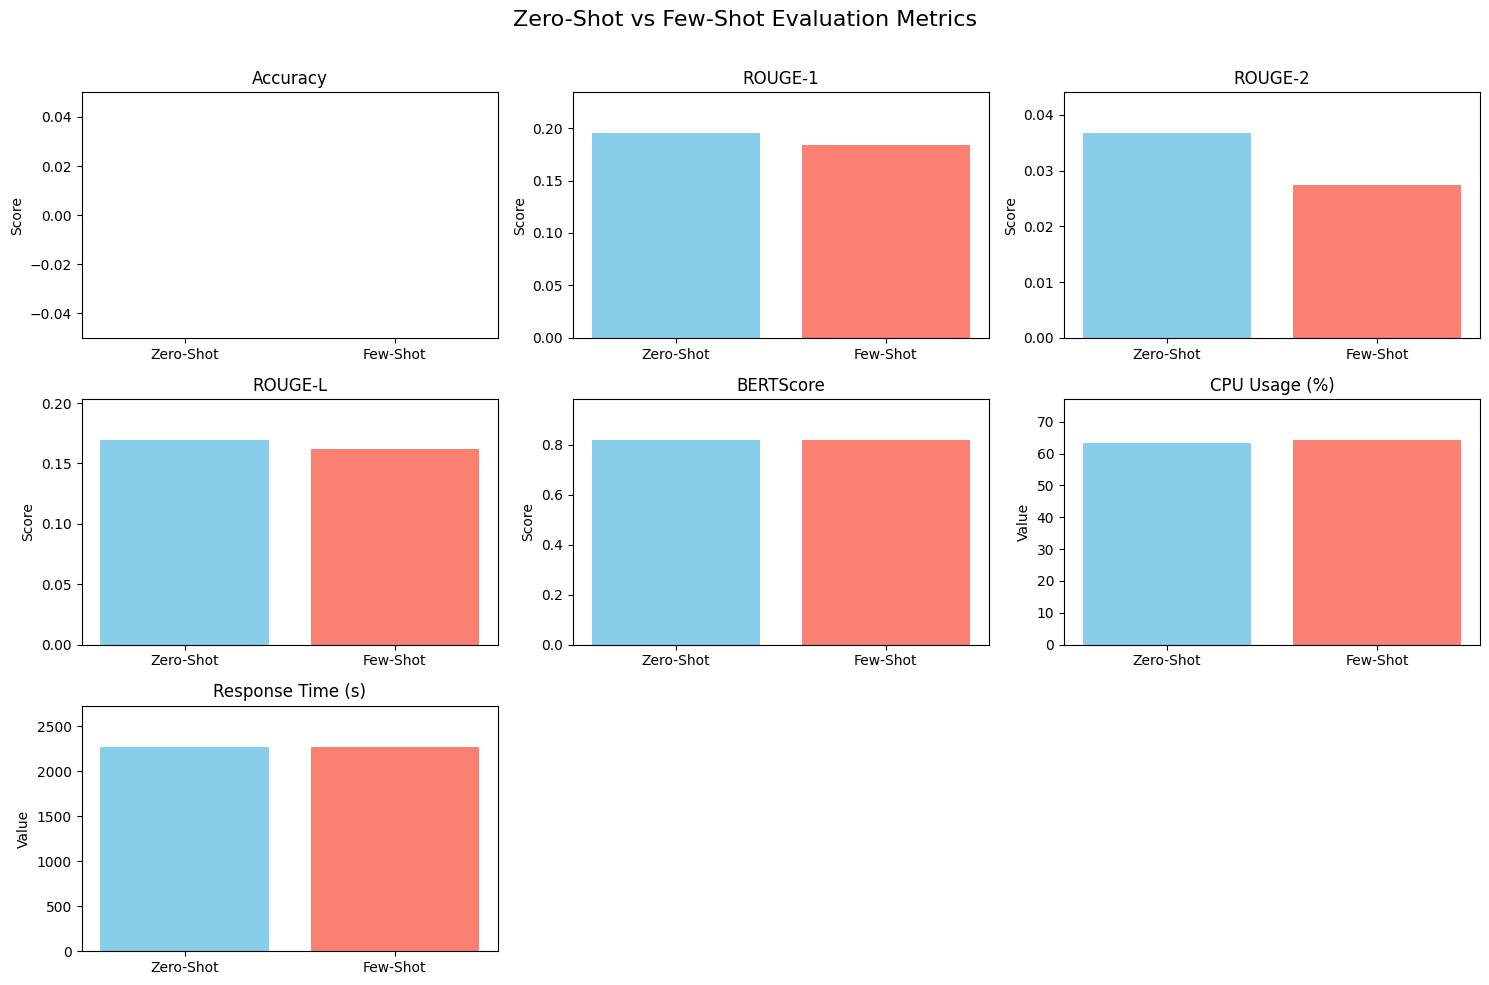

In [29]:
# Plotting
metrics_to_plot = list(comparison_metrics.keys())
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    axes[idx].bar(comparison_df.index, comparison_df[metric], color=["skyblue", "salmon"])
    axes[idx].set_title(metric)
    axes[idx].set_ylabel("Score" if "ROUGE" in metric or "BERT" in metric or "Accuracy" in metric else "Value")
    axes[idx].set_ylim(0, max(comparison_df[metric]) * 1.2)

# Remove unused subplots
for j in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Zero-Shot vs Few-Shot Evaluation Metrics", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [30]:
# Print each metric side-by-side
print(f"{'Metric':<20} {'Zero-Shot':<15} {'Few-Shot'}")
print("="*50)
for metric, values in comparison_metrics.items():
    print(f"{metric:<20} {values[0]:<15.6f} {values[1]:.6f}")

Metric               Zero-Shot       Few-Shot
Accuracy             0.000000        0.000000
ROUGE-1              0.195018        0.184140
ROUGE-2              0.036704        0.027507
ROUGE-L              0.169444        0.161605
BERTScore            0.820085        0.819171
CPU Usage (%)        63.300000       64.300000
Response Time (s)    2275.019806     2274.813833
